In [1]:
!pip install ipympl

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pennylane.templates import RandomLayers
import matplotlib.animation as animation

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 200    # Size of the train dataset
n_test = 120     # Size of the test dataset
n_batches = 4     # Size of the batches

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

n_qubits = 4
random_weights = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))
dev = qml.device("default.qubit.tf", wires=n_qubits)

@qml.qnode(dev, interface='tf')
def qrandnode(inputs):
    for j in range(4):
        qml.RY(np.pi * inputs[j], wires=j)

    # Random quantum circuit
    RandomLayers(random_weights, wires=list(range(n_qubits)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]


@qml.qnode(dev, interface='tf')
def qnotnode(inputs):
    for j in range(4):
        qml.RY(np.pi * inputs[j], wires=j)

    # Filter from arxiv.org/abs/2308.14930
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 3])

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]


@qml.qnode(dev, interface='tf')
def qhadrandnode(inputs):
    for j in range(4):
        qml.RY(np.pi * inputs[j], wires=j)


    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 3])
    qml.Hadamard(wires=[1])
    qml.Hadamard(wires=[2])
    qml.ctrl(qml.Hadamard, control=1)(wires=2)
    qml.ctrl(qml.Hadamard, control=2)(wires=0)
    qml.ctrl(qml.Hadamard, control=1)(wires=2)
    qml.ctrl(qml.Hadamard, control=0)(wires=3)
    qml.Hadamard(wires=[1])
    qml.Hadamard(wires=[0])
    qml.Hadamard(wires=[3])

    
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

def quanv(image, func):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = func(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

anim = ""    
anims = []

ims = []
    
def vizquanv(inputs, func, tittle):

    out = np.zeros((14, 14, 4))
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    for c in range(n_qubits):
        ims.append([[]])
        ax[c].set_title("{tittle} [ch. {c}]".format(tittle=tittle,c=c), fontsize=16)
        ax[c].axis('off')
        ax[c].imshow(quanv(inputs, func)[:,:,c])

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = func(
                [
                    inputs[j, k, 0],
                    inputs[j, k + 1, 0],
                    inputs[j + 1, k, 0],
                    inputs[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_qubits):
                out[j // 2, k // 2, c] = q_results[c]
                im = ax[c].imshow(out[:,:,c], animated=True)
                ims[c].append([im])
    for c in range(n_qubits):
        ims[c].insert(0,ims[c][-1])
        anim = animation.ArtistAnimation(fig, ims[c], interval=100, blit=True,
                                repeat_delay=9000)
        anims.append([anim])
        
    return out

2024-05-14 00:06:47.714609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 00:06:47.714654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 00:06:47.715600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 00:06:47.721520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 00:06:48.461765: W tensorflow/comp

## QRAND

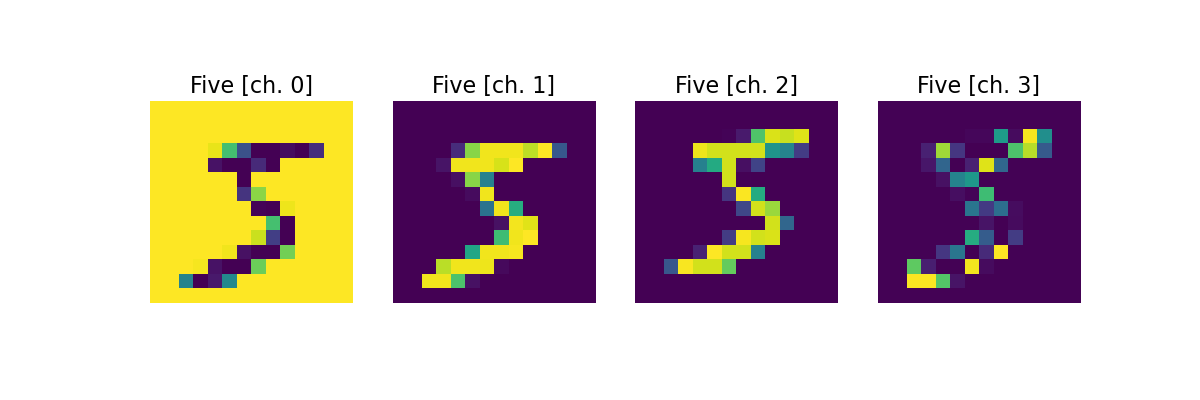

In [3]:
 
%matplotlib widget

ou = vizquanv(train_images[0], qrandnode, "Five")

#plt.tight_layout()
plt.show()


## QNOT

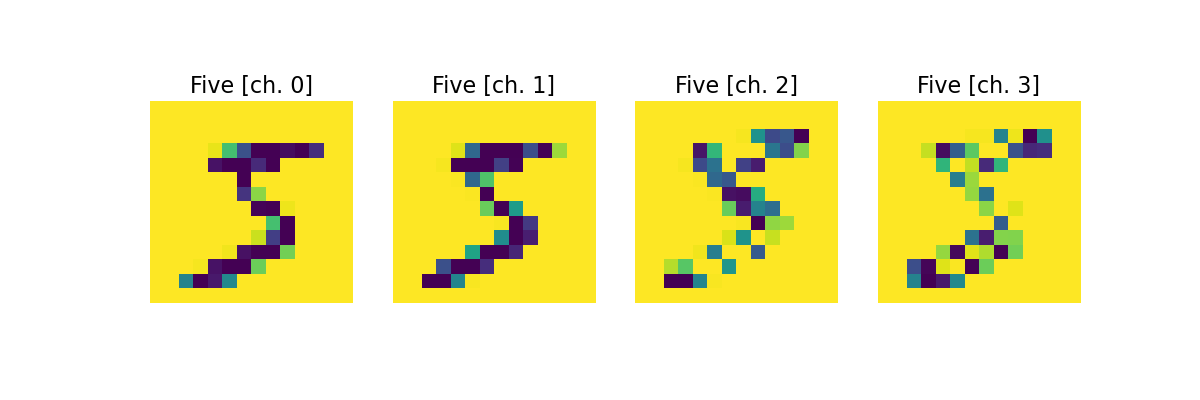

In [4]:
%matplotlib widget

ou = vizquanv(train_images[0], qnotnode, "Five")

#plt.tight_layout()
plt.show()

## QHADRAND

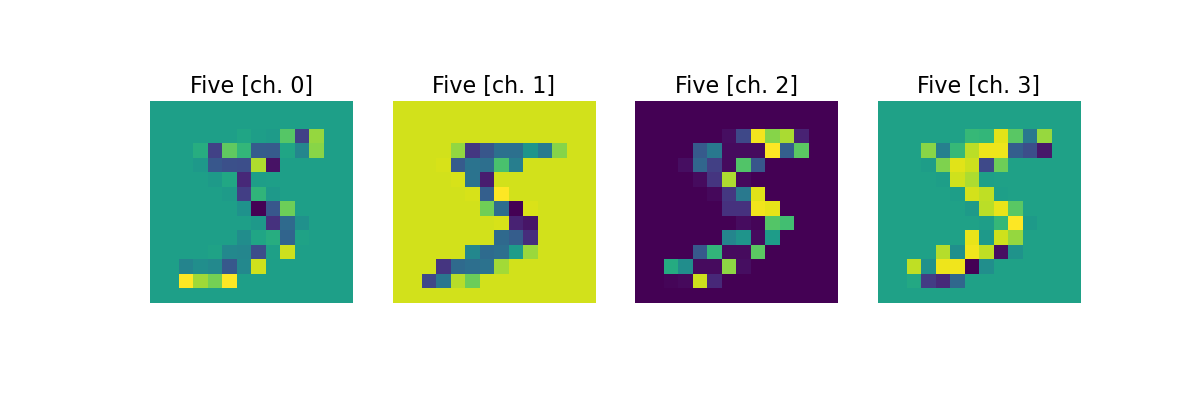

In [5]:
%matplotlib widget

ou = vizquanv(train_images[0], qhadrandnode, "Five")

#plt.tight_layout()
plt.show()